In [1]:
# Set up IPython to show all outputs from a cell
import warnings
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
VERBOSE = 0
SAVE_MODEL = True
RNN_CELLS = 128

In [2]:
# check whether GPU is on
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import pandas as pd
import numpy as np

# Read in data
data = pd.read_csv(
    '../data/neural_network_patent_query.csv', parse_dates=['patent_date'])

# Extract abstracts
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

data.head()

3522

patent_abstract patent_date  \
0  " A ""Barometer"" Neuron enhances stability in...  1996-07-09   
1  " This invention is a novel high-speed neural ...  1993-10-19   
2  An optical information processor for use as a ...  1995-01-17   
3  A method and system for intelligent control of...  2001-01-02   
4  A method and system for intelligent control of...  2003-06-17   

  patent_number                                       patent_title  
0       5535303        """Barometer"" neuron for a neural network"  
1       5255349  "Electronic neural network for solving ""trave...  
2       5383042  3 layer liquid crystal neural network with out...  
3       6169981  3-brain architecture for an intelligent decisi...  
4       6581048  3-brain architecture for an intelligent decisi...

In [4]:
def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

In [8]:
from keras.preprocessing.text import Tokenizer

example = 'This is a short sentence (1) with one reference to an image. This next sentence, while non-sensical, does not have an image and has two commas.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)

'this is a short sentence 1 with one reference to an image this next sentence while non sensical does not have an image and has two commas'

In [9]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence (1) with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

dict_keys(['this', 'an', 'is', 'a', 'short', 'sentence', '(1)', 'with', 'one', 'reference', 'to', 'image.', 'next', 'sentence,', 'while', 'non-sensical,', 'does', 'not', 'have', 'image', 'and', 'has', 'two', 'commas.'])

In [10]:
import re


def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    return patent


f = format_patent(example)
f

'This is a short sentence with one reference to an image . This next sentence , while non-sensical , does not have an image and has two commas .'

In [11]:
formatted = []

# Iterate through all the original abstracts
for a in original_abstracts:
    formatted.append(format_patent(a))

len(formatted)

3522

In [12]:
TRAINING_LENGTH = 50

filters = '!"%;[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=False, filters=filters)

There are 16192 unique words.
There are 318563 training sequences.


In [13]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 30760),
 ('a', 21442),
 ('of', 20157),
 ('.', 16554),
 (',', 15415),
 ('and', 12563),
 ('to', 12012),
 ('network', 7618),
 ('neural', 7235),
 ('is', 7211),
 ('for', 6779),
 ('in', 6131),
 ('The', 5813),
 ('an', 5286),
 ('data', 3971)]

In [14]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [15]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = '/home/jwq/.keras/datasets/glove.6B.zip'

# Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip',
                             'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = '/home/jwq/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape
glove[0]

(400000, 101)

array(['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172',
       '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459',
       '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231',
       '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336',
       '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971',
       '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722',
       '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397',
       '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531',
       '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477',
       '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205',
       '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167',
       '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079',
       '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044',
       '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972',
       '0.15006', '-0.53

In [17]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

In [18]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 6317 words without pre-trained embeddings.


In [19]:
embedding_matrix = np.zeros((num_words, len(word_lookup['the'])))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')
embedding_matrix.shape

There were 6317 words without pre-trained embeddings.


(16192, 100)

In [20]:
# Split into training and validation
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape, y_train.shape

((222994, 50), (222994, 16192))

In [21]:
import sys
sys.getsizeof(y_train) / 1e9

def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB.')

check_sizes(gb_min=1)

3.61071896

Object: y_train   	Size: 3.61071896 GB.
Object: y_valid   	Size: 1.54745336 GB.


In [23]:
# model
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional, SimpleRNN
from keras.optimizers import Adam

from keras.utils import plot_model

def make_word_level_model(num_words,
                          embedding_matrix,
                          rnn_cells=128,
                          trainable=False,
                          rnn_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of RNN cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple RNN layers
    if rnn_layers > 1:
        for i in range(rnn_layers - 1):
            model.add(
                SimpleRNN(
                    rnn_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final RNN cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                SimpleRNN(
                    rnn_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            SimpleRNN(
                rnn_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
#     model.add(Dense(128, activation='relu'))
#     # Dropout for regularization
#     model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    rnn_cells=RNN_CELLS,
    trainable=False,
    rnn_layers=1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1619200   
_________________________________________________________________
masking_2 (Masking)          (None, None, 100)         0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_2 (Dense)              (None, 16192)             2088768   
Total params: 3,737,280
Trainable params: 2,118,080
Non-trainable params: 1,619,200
_________________________________________________________________


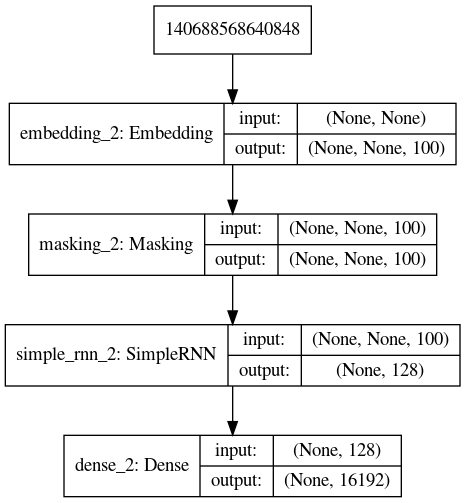

In [26]:
from IPython.display import Image
model_name = 'train-embeddings-rnn-50'
model_dir = '../my_models/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

In [30]:
model_name = 'train-embeddings-rnn-50'
callbacks = make_callbacks(model_name)

In [32]:
model.compile(
    optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

KeyboardInterrupt: 

In [ ]:
model = load_and_evaluate(model_name, return_model=True)